In [ ]:
from google.colab import drive        # Google Drive를 Colab에 연결해서 데이터 로딩하기
drive.mount('/content/drive')         # 드라이브 마운트

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import ImageDataGenerator   #keras로부터 ImageDataGenerator를 불러옵니다
import numpy as np
import pandas as pd 
from keras.utils import to_categorical                     #데이터를 다루는데 필요한 라이브러리를 불러옵니다.
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir('/content/drive/MyDrive/deep_learning/팀플/data/'))   #os.listdir() 메서드는 경로 내에 있는 파일의 
                                                                       #이름을 리스트의 형태로 반환합니다.

['sampleSubmission.csv', 'test1.zip', 'train.zip']


In [ ]:
import zipfile
train_zip = zipfile.ZipFile('/content/drive/MyDrive/deep_learning/팀플/data/train.zip')  #zipfile 라이브러리의 ZipFile 클래스로 ZIP 파일을 연 후에
train_zip.extractall("/kaggle/working/dataset")                                          #extractall() 메서드를 이용하여 kaggle/working/dataset 폴더에 압축을 풉니다.
train_zip.close()                                                                        #종료 전 close를 호출하여 필수 레코드 기록

train_zip = zipfile.ZipFile('/content/drive/MyDrive/deep_learning/팀플/data/test1.zip')
train_zip.extractall("/kaggle/working/dataset")
train_zip.close()

In [ ]:
filenames = os.listdir("/kaggle/working/dataset/train")      #os.listdir() 메서드는 경로 내에 있는 파일의 이름을 리스트의 형태로 반환합니다.
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':                           #dog는1 cat은0으로 분류합니다
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df = df.sample(n=3000)    # DataFrame으로 부터 특정 개수의 표본을 3000개 추출하기 

In [ ]:
# 데이터 형상 관련 상수 정의
IMAGE_WIDTH=150                            #가로 150으로 설정
IMAGE_HEIGHT=150                           #세로 150으로 설정
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)     #150x150의 크기
IMAGE_CHANNELS=3

In [ ]:
import tensorflow as tf                 #텐서플로를 import 해주고
                                        #model에 순차적으로 레이어를 쌓아줌

                                                                                                                   #tf.keras.models 모듈의 Sequential 클래스를 사용해서 인공신경망의 각 층을 순서대로 쌓아줌                                                            
model = tf.keras.models.Sequential([                                                                               #add() 메서드를 이용해서 합성곱 층 Conv2D와 Max pooling 층 MaxPooling2D를 반복해서 구성 
  tf.keras.layers.Conv2D(32, (3,3), activation='relu',  input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),  #첫번째 Conv2D 층의 첫번째 인자 32는 filters 값  #두번째 인자 (3, 3)은 kernel_size 값  ,활성화 함수는 relu 지정                                                                                                       
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),                                                                           
  tf.keras.layers.MaxPooling2D(2,2),                                                                               #풀링의 크기는 2X2로 설정
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

model.summary()             #summary() 메서드를 이용해서 지금까지 구성한 신경망에 대한 정보를 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 128)      0         
 2D)                                                    

In [ ]:
from tensorflow.keras.optimizers import RMSprop         #변화량이 더 클수록 학습률이 작아져서
                                                        #조기 종료되는 문제를 해결하기 위해 학습률 크기를 비율로 조정할 수 있어서 RMSprop사용
model.compile(optimizer=RMSprop(lr=0.001),              #학습률 같은 경우 일반적으로 0.01을 사용함
            loss='categorical_crossentropy',            #손실함수로는 categorical_crossentropy 사용함
            metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# 이미지 제너레이터에서 class_mode = "categorical"로 지정하기 위해 컬럼 카테고리를 스트링으로 변경함.
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})       #cat는 0 , dog는 1을 반환함

In [ ]:
#test , train 데이터 분리 
train_df, validate_df = train_test_split(df, test_size=0.3333, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
#이미지 데이터 전처리
#트레이닝 데이터의 제너레이터 설정

train_datagen = ImageDataGenerator(
    rotation_range=15,      #rotation_range는 랜덤하게 사진을 회전시킬 각도 범위
    rescale=1./255,         #이미지를 1/255로 스케일을 조정 
    shear_range=0.1,        #shear_range는 랜덤하게 전단 변환을 적용할 각도 범위 
    zoom_range=0.2,         #zoom_range는 랜덤하게 사진을 확대할 범위
    horizontal_flip=True,   #horizontal_flip은 랜덤하게 이미지를 수평으로 뒤집는다./수평 대칭을 가정할 수 있을 때 사용
    width_shift_range=0.1,  #width_shift_range와 
    height_shift_range=0.1  #height_shift_range는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/working/dataset/train", 
    x_col='filename',                   # filename를 열이름
    y_col='category',                   # category를 열이름
    target_size=IMAGE_SIZE,             #이미지 사이즈
    class_mode='categorical',           #y값 변화방법
    batch_size=batch_size               #배치사이즈
)


Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)         #이미지를 1/255로 스케일을 조정
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/working/dataset/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1000 validated image filenames belonging to 2 classes.


In [ ]:
epochs=10                                  #에포크는 10으로 지정
history = model.fit_generator(
    train_generator,                                #훈련데이터셋을 제공할 제네레이터를 train_generator으로 지정
    epochs=epochs,                                  #전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정
    validation_data=validation_generator,           #검증데이터셋을 제공할 제네레이터를 validation_generator으로 지정
    validation_steps=total_validate//batch_size,    #한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정
    steps_per_epoch=total_train//batch_size,
    verbose = 1
)

<ipython-input-15-76eee772cb9b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
133/133 [==============================] - 327s 2s/step - loss: 1.1305 - accuracy: 0.5174 - val_loss: 0.7068 - val_accuracy: 0.5758
Epoch 2/10
133/133 [==============================] - 322s 2s/step - loss: 0.7191 - accuracy: 0.5763 - val_loss: 0.6835 - val_accuracy: 0.5616
Epoch 3/10
133/133 [==============================] - 312s 2s/step - loss: 0.6875 - accuracy: 0.5929 - val_loss: 0.6482 - val_accuracy: 0.6374
Epoch 4/10
133/133 [==============================] - 317s 2s/step - loss: 0.6648 - accuracy: 0.6322 - val_loss: 0.6565 - val_accuracy: 0.6303
Epoch 5/10
133/133 [==============================] - 314s 2s/step - loss: 0.6442 - accuracy: 0.6312 - val_loss: 0.6352 - val_accuracy: 0.6768
Epoch 6/10
133/133 [==============================] - 309s 2s/step - loss: 0.6202 - accuracy: 0.6761 - val_loss: 0.7656 - val_accuracy: 0.5758
Epoch 7/10
133/133 [==============================] - 312s 2s/step - loss: 0.6097 - accuracy: 0.6710 - val_loss: 0.6508 - val_accuracy: 0.6485

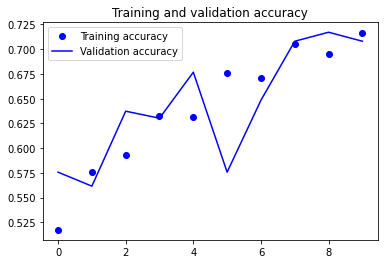

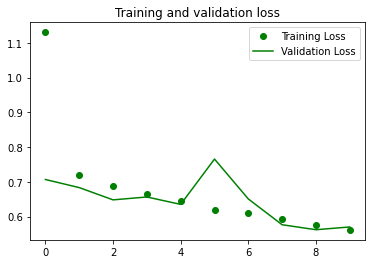

In [ ]:
import matplotlib.pyplot as plt
#트레이닝 모델 히스토리 시각화

#아래 항목들은 매 epoch 마다의 값들이 저장되어 있습니다.
#acc : 훈련 정확도
#val_acc : 검증 정확도
#loss : 훈련 손실값
#val_loss : 검증 손실값

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Training accuracy , Validation accuracy 시각화
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Training Loss , Validation Loss 시각화
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()    #그래프와 점으로 보여줌

## submission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/deep_learning/팀플/data/sampleSubmission.csv')

In [ ]:
test = os.listdir("/kaggle/working/dataset/test1")

test_df = pd.DataFrame({'filename': test})

nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/dataset/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
# 예측진행
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-20-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
# 컬럼 카테고리를 스트링으로 변경함.
#cat는 0 , dog는 1을 반환함
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

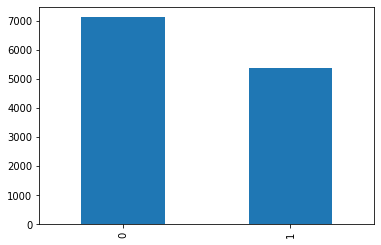

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
# submission에 저장
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]  # submission의 id 부분 생성
submission_df['label'] = submission_df['category']                     # submission의 label 부분 생성
submission_df.drop(['filename', 'category'], axis=1, inplace=True)     # 기존 열 삭제

In [ ]:
submission_df # 내부 확인

,id,label
0,7083,1
1,9125,0
2,7560,0
3,9368,0
4,10137,0
...,...,...
12495,6143,0
12496,6562,0
12497,8794,1
12498,2453,0


In [ ]:
submission_df.to_csv('/content/drive/MyDrive/deep_learning/팀플/submission.csv', index=False) # csv 파일 생성